### Test metrics on official chexpert validation set (test set for this project)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, multilabel_confusion_matrix, roc_auc_score, roc_curve

# Custom objects required for loading CheXpert multi-label classification models
import sys 
sys.path.append('..')
from loss import (
    set_binary_crossentropy_weighted_loss
)

2021-11-28 20:32:47.278150: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### 1- Loading test set

In [2]:
test_df = pd.read_csv(
    filepath_or_buffer="../labels/train_validation_split_data/test_u-zeroes.csv",
    dtype={  # Setting labels to type np.float32 was necessary for conversion to tf.Tensor object
        "Path": str,
        "Atelectasis": np.float32,
        "Cardiomegaly": np.float32,
        "Consolidation": np.float32,
        "Edema": np.float32,
        "Pleural Effusion": np.float32,
        "Pleural Other": np.float32,
        "Pneumonia": np.float32,
        "Pneumothorax": np.float32,
        "Enlarged Cardiomediastinum": np.float32,
        "Lung Opacity": np.float32,
        "Lung Lesion": np.float32,
        "Fracture": np.float32,
        "Support Devices": np.float32,
        "No Finding": np.float32
    }
)

In [3]:
list_columns = list(test_df.columns)
y_cols = list_columns[1::]  # First column is 'Path' column

In [4]:
list_columns

['Path',
 'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Pleural Effusion',
 'Pleural Other',
 'Pneumonia',
 'Pneumothorax',
 'Enlarged Cardiomediastinum',
 'Lung Opacity',
 'Lung Lesion',
 'Fracture',
 'Support Devices',
 'No Finding']

In [5]:
y_cols

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Pleural Effusion',
 'Pleural Other',
 'Pneumonia',
 'Pneumothorax',
 'Enlarged Cardiomediastinum',
 'Lung Opacity',
 'Lung Lesion',
 'Fracture',
 'Support Devices',
 'No Finding']

In [6]:
test_datagen = ImageDataGenerator(
    featurewise_center=True,  # Mean and standard deviation values of the training set will be loaded to the object
    featurewise_std_normalization=True
)

In [7]:
training_dataset_mean = np.load("../misc/calculated_chexpert_training_dataset_mean_and_std_values/CheXpert_training_set_mean.npy")
training_dataset_std = np.load("../misc/calculated_chexpert_training_dataset_mean_and_std_values/CheXpert_training_set_std.npy")

In [8]:
test_datagen.mean = training_dataset_mean
test_datagen.std = training_dataset_std

test_datagenerator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="../dataset/",
    x_col='Path',
    y_col=y_cols,
    weight_col=None,
    target_size=(512, 512),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=1,
    validate_filenames=True,
    shuffle=False
)

Found 234 validated image filenames.


### 2- Loading models

In [9]:
densenet201_model = load_model(
    "../trained_models/densenet201.h5",
    custom_objects={
        "binary_crossentropy_weighted_loss": set_binary_crossentropy_weighted_loss
    }
)

inceptionresnetv2_model = load_model(
    "../trained_models/inceptionresnetv2.h5",
    custom_objects={
        "binary_crossentropy_weighted_loss": set_binary_crossentropy_weighted_loss
    }
)

ensemble_model = load_model(
    "../trained_models/ensemble-model.h5",
    custom_objects={
        "binary_crossentropy_weighted_loss": set_binary_crossentropy_weighted_loss
    }
)

2021-11-28 20:32:48.731289: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-28 20:32:48.731830: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-28 20:32:48.780061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 20:32:48.780685: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2021-11-28 20:32:48.780702: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-28 20:32:48.781843: I tensorflow/stream_executor/platform/default/d

### 3- Predictions

In [10]:
predictions_densenet201_model_probabilities = densenet201_model.predict(
    x=test_datagenerator,
    steps=len(test_datagenerator),
    workers=1,
    verbose=1
)

# "Sigmoid" activation for output probabilities
predictions_densenet201_model = (predictions_densenet201_model_probabilities >= 0.5).astype(np.uint8)

2021-11-28 20:33:05.183722: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-28 20:33:05.202208: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz
2021-11-28 20:33:07.238484: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-28 20:33:07.365945: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-11-28 20:33:08.063795: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-11-28 20:33:08.102789: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


234/234 [==============================] - 51s 19ms/step


In [11]:
predictions_inceptionresnetv2_model_probabilities = inceptionresnetv2_model.predict(
    x=test_datagenerator,
    steps=len(test_datagenerator),
    workers=1,
    verbose=1
)

# "Sigmoid" activation for output probabilities
predictions_inceptionresnetv2_model = (predictions_inceptionresnetv2_model_probabilities >= 0.5).astype(np.uint8)

234/234 [==============================] - 23s 25ms/step


In [12]:
predictions_ensemble_model_probabilities = ensemble_model.predict(
    x=test_datagenerator,
    steps=len(test_datagenerator),
    workers=1,
    verbose=1
)

# "Sigmoid" activation for output probabilities
predictions_ensemble_model = (predictions_ensemble_model_probabilities >= 0.5).astype(np.uint8)

234/234 [==============================] - 14s 45ms/step


### All CheXpert labels (all 14 labels)

In [13]:
labels = y_cols

In [14]:
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Pleural Effusion',
 'Pleural Other',
 'Pneumonia',
 'Pneumothorax',
 'Enlarged Cardiomediastinum',
 'Lung Opacity',
 'Lung Lesion',
 'Fracture',
 'Support Devices',
 'No Finding']

#### 1- DenseNet-201 model

##### 1.1 Classification Report

In [15]:
report_densenet201_model = classification_report(
    y_true=test_datagenerator.labels,
    y_pred=predictions_densenet201_model,
    digits=4,
    target_names=labels
)

print("DenseNet-201:\n")
print(report_densenet201_model)

DenseNet-201:

                            precision    recall  f1-score   support

               Atelectasis     0.5429    0.4750    0.5067        80
              Cardiomegaly     0.6136    0.3971    0.4821        68
             Consolidation     0.3860    0.6667    0.4889        33
                     Edema     0.5556    0.6667    0.6061        45
          Pleural Effusion     0.7424    0.7313    0.7368        67
             Pleural Other     0.0169    1.0000    0.0333         1
                 Pneumonia     0.1042    0.6250    0.1786         8
              Pneumothorax     0.1290    0.5000    0.2051         8
Enlarged Cardiomediastinum     0.5694    0.3761    0.4530       109
              Lung Opacity     0.8519    0.7302    0.7863       126
               Lung Lesion     0.0000    0.0000    0.0000         1
                  Fracture     0.0000    0.0000    0.0000         0
           Support Devices     0.8738    0.8411    0.8571       107
                No Finding     0

/home/tamer/anaconda3/envs/chexpert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tamer/anaconda3/envs/chexpert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### 1.2 Confusion Matrix

In [16]:
confusion_matrix_densenet201 = multilabel_confusion_matrix(
    y_true=test_datagenerator.labels,
    y_pred=predictions_densenet201_model
)

print("DenseNet-201:\n\n")
for i in range(len(labels)):
    print(f"{labels[i]}:\n")
    print(confusion_matrix_densenet201[i, :, :])
    print("------------")

DenseNet-201:


Atelectasis:

[[122  32]
 [ 42  38]]
------------
Cardiomegaly:

[[149  17]
 [ 41  27]]
------------
Consolidation:

[[166  35]
 [ 11  22]]
------------
Edema:

[[165  24]
 [ 15  30]]
------------
Pleural Effusion:

[[150  17]
 [ 18  49]]
------------
Pleural Other:

[[175  58]
 [  0   1]]
------------
Pneumonia:

[[183  43]
 [  3   5]]
------------
Pneumothorax:

[[199  27]
 [  4   4]]
------------
Enlarged Cardiomediastinum:

[[94 31]
 [68 41]]
------------
Lung Opacity:

[[92 16]
 [34 92]]
------------
Lung Lesion:

[[151  82]
 [  1   0]]
------------
Fracture:

[[156  78]
 [  0   0]]
------------
Support Devices:

[[114  13]
 [ 17  90]]
------------
No Finding:

[[133  63]
 [  3  35]]
------------


##### 1.3 Receiver Operating Characteristic curve (ROC Curve)

Error in generating ROC curve for Fracture. Dataset lacks enough examples.


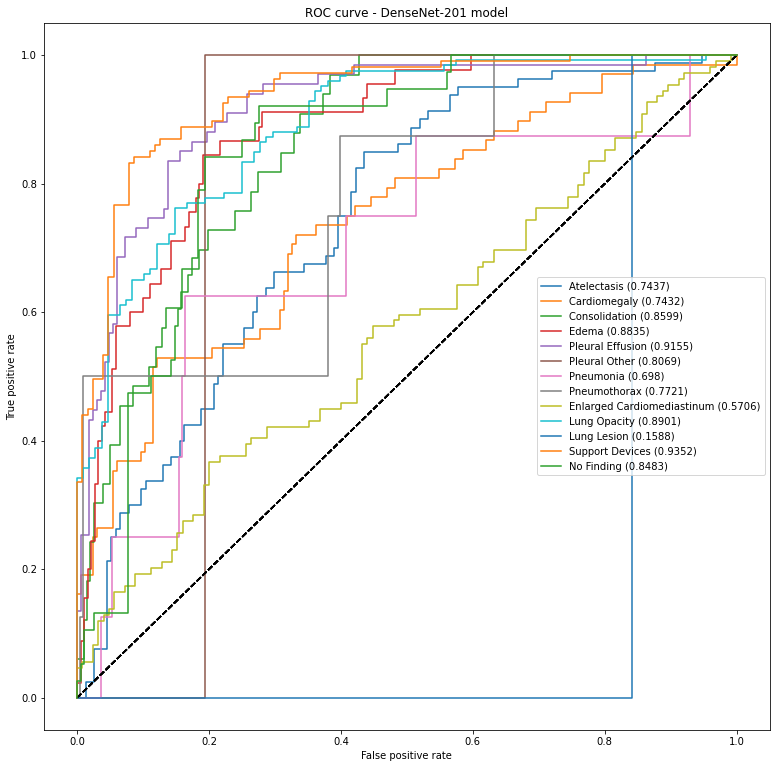

In [17]:
auc_roc_values = []

for i in range(len(labels)):
    try:
        y_true = test_datagenerator.labels[:, i]
        y_pred = predictions_densenet201_model_probabilities[:, i]
        
        auc_roc = roc_auc_score(y_true=y_true, y_score=y_pred)
        auc_roc_values.append(auc_roc)
        
        false_positive_rates, true_positive_rates, _ = roc_curve(y_true=y_true, y_score=y_pred)

        plt.figure(1, figsize=(13, 13))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(
            false_positive_rates,
            true_positive_rates,
            label=labels[i] + " (" + str(round(auc_roc, 4)) + ")"
        )
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve - DenseNet-201 model')
        plt.legend(loc='best')
    except:
        print(
            f"Error in generating ROC curve for {labels[i]}. "
            f"Dataset lacks enough examples."
        )

plt.show()

In [18]:
auc_roc_values

[0.7436688311688313,
 0.7431785967399007,
 0.8599427106889792,
 0.883480305702528,
 0.9154526767360801,
 0.8068669527896996,
 0.6980088495575222,
 0.7721238938053097,
 0.5705688073394496,
 0.8900646678424455,
 0.15879828326180256,
 0.9351681507101333,
 0.84828141783029]

#### 2- Inception-ResNet-V2 model

##### 2.1 Classification Report

In [19]:
report_inceptionresnetv2_model = classification_report(
    y_true=test_datagenerator.labels,
    y_pred=predictions_inceptionresnetv2_model,
    digits=4,
    target_names=labels
)

print("Inception-ResNet-V2:\n")
print(report_inceptionresnetv2_model)

Inception-ResNet-V2:

                            precision    recall  f1-score   support

               Atelectasis     0.6190    0.4875    0.5455        80
              Cardiomegaly     0.6809    0.4706    0.5565        68
             Consolidation     0.4242    0.8485    0.5657        33
                     Edema     0.6182    0.7556    0.6800        45
          Pleural Effusion     0.7895    0.6716    0.7258        67
             Pleural Other     0.0164    1.0000    0.0323         1
                 Pneumonia     0.0455    0.2500    0.0769         8
              Pneumothorax     0.0962    0.6250    0.1667         8
Enlarged Cardiomediastinum     0.5233    0.4128    0.4615       109
              Lung Opacity     0.8818    0.7698    0.8220       126
               Lung Lesion     0.0000    0.0000    0.0000         1
                  Fracture     0.0000    0.0000    0.0000         0
           Support Devices     0.8901    0.7570    0.8182       107
                No Findin

/home/tamer/anaconda3/envs/chexpert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tamer/anaconda3/envs/chexpert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### 2.2 Confusion Matrix

In [20]:
confusion_matrix_inceptionresnetv2 = multilabel_confusion_matrix(
    y_true=test_datagenerator.labels,
    y_pred=predictions_inceptionresnetv2_model
)

print("Inception-ResNet-V2:\n\n")
for i in range(len(labels)):
    print(f"{labels[i]}:")
    print(confusion_matrix_inceptionresnetv2[i, :, :])
    print("------------")

Inception-ResNet-V2:


Atelectasis:
[[130  24]
 [ 41  39]]
------------
Cardiomegaly:
[[151  15]
 [ 36  32]]
------------
Consolidation:
[[163  38]
 [  5  28]]
------------
Edema:
[[168  21]
 [ 11  34]]
------------
Pleural Effusion:
[[155  12]
 [ 22  45]]
------------
Pleural Other:
[[173  60]
 [  0   1]]
------------
Pneumonia:
[[184  42]
 [  6   2]]
------------
Pneumothorax:
[[179  47]
 [  3   5]]
------------
Enlarged Cardiomediastinum:
[[84 41]
 [64 45]]
------------
Lung Opacity:
[[95 13]
 [29 97]]
------------
Lung Lesion:
[[150  83]
 [  1   0]]
------------
Fracture:
[[164  70]
 [  0   0]]
------------
Support Devices:
[[117  10]
 [ 26  81]]
------------
No Finding:
[[129  67]
 [  3  35]]
------------


##### 2.3 Receiver Operating Characteristic curve (ROC Curve)

Error in generating ROC curve for Fracture. Dataset lacks enough examples.


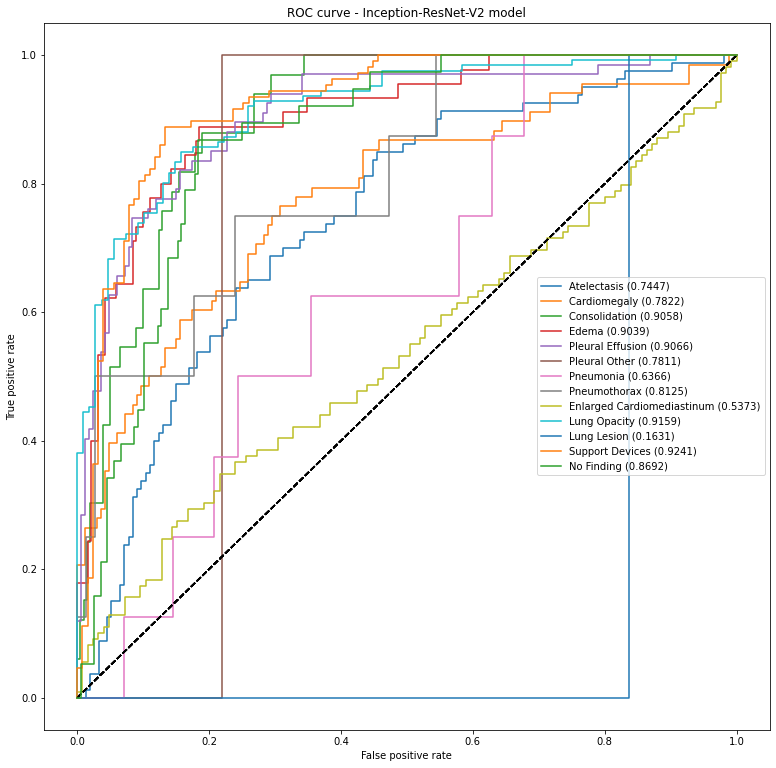

In [21]:
auc_roc_values = []

for i in range(len(labels)):
    try:
        y_true = test_datagenerator.labels[:, i]
        y_pred = predictions_inceptionresnetv2_model_probabilities[:, i]
        
        auc_roc = roc_auc_score(y_true=y_true, y_score=y_pred)
        auc_roc_values.append(auc_roc)
        
        false_positive_rates, true_positive_rates, _ = roc_curve(y_true=y_true, y_score=y_pred)

        plt.figure(1, figsize=(13, 13))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(
            false_positive_rates,
            true_positive_rates,
            label=labels[i] + " (" + str(round(auc_roc, 4)) + ")"
        )
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve - Inception-ResNet-V2 model')
        plt.legend(loc='best')
    except:
        print(
            f"Error in generating ROC curve for {labels[i]}. "
            f"Dataset lacks enough examples."
        )

plt.show()

In [22]:
auc_roc_values

[0.744724025974026,
 0.7822466335931963,
 0.9057741595055028,
 0.9039388594944151,
 0.9066047010456698,
 0.7811158798283262,
 0.6366150442477876,
 0.8125,
 0.5373211009174312,
 0.9159318048206937,
 0.16309012875536477,
 0.9241298108764442,
 0.8692266380236305]

#### 3- Ensemble model

##### 3.1 Classification Report

In [23]:
report_ensemble_model = classification_report(
    y_true=test_datagenerator.labels,
    y_pred=predictions_ensemble_model,
    digits=4,
    target_names=labels
)

print(report_ensemble_model)

                            precision    recall  f1-score   support

               Atelectasis     0.5634    0.5000    0.5298        80
              Cardiomegaly     0.6667    0.4118    0.5091        68
             Consolidation     0.4032    0.7576    0.5263        33
                     Edema     0.6327    0.6889    0.6596        45
          Pleural Effusion     0.7966    0.7015    0.7460        67
             Pleural Other     0.0182    1.0000    0.0357         1
                 Pneumonia     0.0769    0.3750    0.1277         8
              Pneumothorax     0.1111    0.5000    0.1818         8
Enlarged Cardiomediastinum     0.5062    0.3761    0.4316       109
              Lung Opacity     0.8919    0.7857    0.8354       126
               Lung Lesion     0.0000    0.0000    0.0000         1
                  Fracture     0.0000    0.0000    0.0000         0
           Support Devices     0.8788    0.8131    0.8447       107
                No Finding     0.3684    0.9211

/home/tamer/anaconda3/envs/chexpert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tamer/anaconda3/envs/chexpert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### 3.2 Confusion Matrix

In [24]:
confusion_matrix_ensemble = multilabel_confusion_matrix(
    y_true=test_datagenerator.labels,
    y_pred=predictions_ensemble_model
)

print("Ensemble:\n\n")
for i in range(len(labels)):
    print(f"{labels[i]}:")
    print(confusion_matrix_ensemble[i, :, :])
    print("------------")

Ensemble:


Atelectasis:
[[123  31]
 [ 40  40]]
------------
Cardiomegaly:
[[152  14]
 [ 40  28]]
------------
Consolidation:
[[164  37]
 [  8  25]]
------------
Edema:
[[171  18]
 [ 14  31]]
------------
Pleural Effusion:
[[155  12]
 [ 20  47]]
------------
Pleural Other:
[[179  54]
 [  0   1]]
------------
Pneumonia:
[[190  36]
 [  5   3]]
------------
Pneumothorax:
[[194  32]
 [  4   4]]
------------
Enlarged Cardiomediastinum:
[[85 40]
 [68 41]]
------------
Lung Opacity:
[[96 12]
 [27 99]]
------------
Lung Lesion:
[[151  82]
 [  1   0]]
------------
Fracture:
[[163  71]
 [  0   0]]
------------
Support Devices:
[[115  12]
 [ 20  87]]
------------
No Finding:
[[136  60]
 [  3  35]]
------------


##### 3.3 Receiver Operating Characteristic curve (ROC Curve)

Error in generating ROC curve for Fracture. Dataset lacks enough examples.


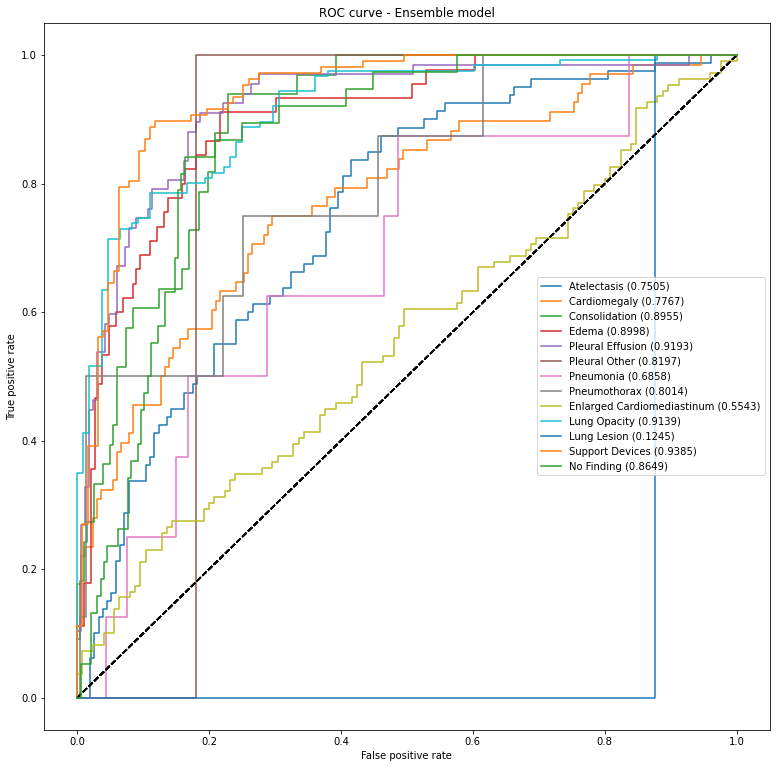

In [25]:
auc_roc_values = []

for i in range(len(labels)):
    try:
        y_true = test_datagenerator.labels[:, i]
        y_pred = predictions_ensemble_model_probabilities[:, i]
        
        auc_roc = roc_auc_score(y_true=y_true, y_score=y_pred)
        auc_roc_values.append(auc_roc)
        
        false_positive_rates, true_positive_rates, _ = roc_curve(y_true=y_true, y_score=y_pred)

        plt.figure(1, figsize=(13, 13))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(
            false_positive_rates,
            true_positive_rates,
            label=labels[i] + " (" + str(round(auc_roc, 4)) + ")"
        )
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve - Ensemble model')
        plt.legend(loc='best')
    except:
        print(
            f"Error in generating ROC curve for {labels[i]}. "
            f"Dataset lacks enough examples."
        )

plt.show()

In [26]:
auc_roc_values

[0.750487012987013,
 0.776665485471297,
 0.8955223880597015,
 0.8998236331569665,
 0.9192957368844401,
 0.8197424892703863,
 0.6858407079646018,
 0.8014380530973452,
 0.5542752293577982,
 0.9139476778365666,
 0.12446351931330468,
 0.9384796526602399,
 0.8649301825993555]

### CheXpert competition labels (first 5 labels only)

In [27]:
# The dataset was modified as to make the first five labels the chexpert competition labels
labels = y_cols[:5]

In [28]:
labels

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

#### 1- DenseNet-201 model

##### 1.1 Classification Report

In [29]:
report_densenet201_model = classification_report(
    y_true=test_datagenerator.labels[:, :5],
    y_pred=predictions_densenet201_model[:, :5],
    digits=4,
    target_names=labels
)

print(report_densenet201_model)

                  precision    recall  f1-score   support

     Atelectasis     0.5429    0.4750    0.5067        80
    Cardiomegaly     0.6136    0.3971    0.4821        68
   Consolidation     0.3860    0.6667    0.4889        33
           Edema     0.5556    0.6667    0.6061        45
Pleural Effusion     0.7424    0.7313    0.7368        67

       micro avg     0.5704    0.5666    0.5685       293
       macro avg     0.5681    0.5873    0.5641       293
    weighted avg     0.5892    0.5666    0.5669       293
     samples avg     0.3386    0.3129    0.3043       293



/home/tamer/anaconda3/envs/chexpert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tamer/anaconda3/envs/chexpert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### 1.2 Confusion Matrix

In [30]:
confusion_matrix_densenet201 = multilabel_confusion_matrix(
    y_true=test_datagenerator.labels[:, :5],
    y_pred=predictions_densenet201_model[:, :5]
)

print("DenseNet-201\n\n")
for i in range(len(labels)):
    print(f"{labels[i]}:")
    print(confusion_matrix_densenet201[i, :, :])
    print("------------")

DenseNet-201


Atelectasis:
[[122  32]
 [ 42  38]]
------------
Cardiomegaly:
[[149  17]
 [ 41  27]]
------------
Consolidation:
[[166  35]
 [ 11  22]]
------------
Edema:
[[165  24]
 [ 15  30]]
------------
Pleural Effusion:
[[150  17]
 [ 18  49]]
------------


##### 1.3 Receiver Operating Characteristic curve (ROC Curve)

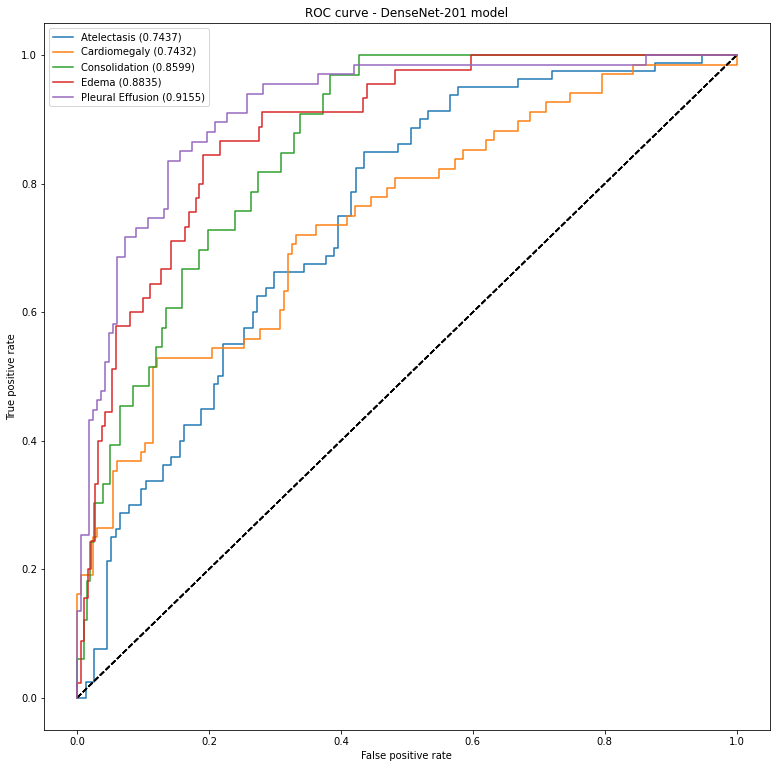

In [31]:
auc_roc_values = []

for i in range(len(labels)):
    try:
        y_true = test_datagenerator.labels[:, i]
        y_pred = predictions_densenet201_model_probabilities[:, i]
        
        auc_roc = roc_auc_score(y_true=y_true, y_score=y_pred)
        auc_roc_values.append(auc_roc)
        
        false_positive_rates, true_positive_rates, _ = roc_curve(y_true=y_true, y_score=y_pred)

        plt.figure(1, figsize=(13, 13))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(
            false_positive_rates,
            true_positive_rates,
            label=labels[i] + " (" + str(round(auc_roc, 4)) + ")"
        )
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve - DenseNet-201 model')
        plt.legend(loc='best')
    except:
        print(
            f"Error in generating ROC curve for {labels[i]}. "
            f"Dataset lacks enough examples."
        )

plt.show()

In [32]:
auc_roc_values

[0.7436688311688313,
 0.7431785967399007,
 0.8599427106889792,
 0.883480305702528,
 0.9154526767360801]

#### 2- Inception-ResNet-V2 model

##### 2.1 Classification Report

In [33]:
report_inceptionresnetv2_model = classification_report(
    y_true=test_datagenerator.labels[:, :5],
    y_pred=predictions_inceptionresnetv2_model[:, :5],
    digits=4,
    target_names=labels
)

print(report_ensemble_model)

                            precision    recall  f1-score   support

               Atelectasis     0.5634    0.5000    0.5298        80
              Cardiomegaly     0.6667    0.4118    0.5091        68
             Consolidation     0.4032    0.7576    0.5263        33
                     Edema     0.6327    0.6889    0.6596        45
          Pleural Effusion     0.7966    0.7015    0.7460        67
             Pleural Other     0.0182    1.0000    0.0357         1
                 Pneumonia     0.0769    0.3750    0.1277         8
              Pneumothorax     0.1111    0.5000    0.1818         8
Enlarged Cardiomediastinum     0.5062    0.3761    0.4316       109
              Lung Opacity     0.8919    0.7857    0.8354       126
               Lung Lesion     0.0000    0.0000    0.0000         1
                  Fracture     0.0000    0.0000    0.0000         0
           Support Devices     0.8788    0.8131    0.8447       107
                No Finding     0.3684    0.9211

/home/tamer/anaconda3/envs/chexpert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tamer/anaconda3/envs/chexpert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### 2.2 Confusion Matrix

In [34]:
confusion_matrix_inceptionresnetv2 = multilabel_confusion_matrix(
    y_true=test_datagenerator.labels[:, :5],
    y_pred=predictions_inceptionresnetv2_model[:, :5]
)

print("Inception-ResNet-V2:\n\n")
for i in range(len(labels)):
    print(f"{labels[i]}:")
    print(confusion_matrix_inceptionresnetv2[i, :, :])
    print("------------")

Inception-ResNet-V2:


Atelectasis:
[[130  24]
 [ 41  39]]
------------
Cardiomegaly:
[[151  15]
 [ 36  32]]
------------
Consolidation:
[[163  38]
 [  5  28]]
------------
Edema:
[[168  21]
 [ 11  34]]
------------
Pleural Effusion:
[[155  12]
 [ 22  45]]
------------


##### 2.3 Receiver Operating Characteristic curve (ROC Curve)

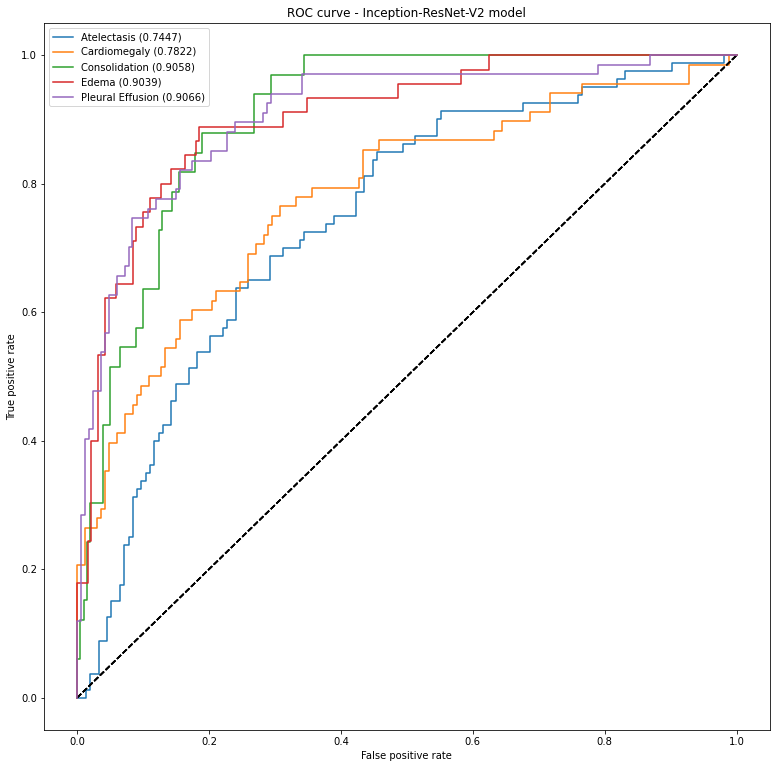

In [35]:
auc_roc_values = []

for i in range(len(labels)):
    try:
        y_true = test_datagenerator.labels[:, i]
        y_pred = predictions_inceptionresnetv2_model_probabilities[:, i]
        
        auc_roc = roc_auc_score(y_true=y_true, y_score=y_pred)
        auc_roc_values.append(auc_roc)
        
        false_positive_rates, true_positive_rates, _ = roc_curve(y_true=y_true, y_score=y_pred)

        plt.figure(1, figsize=(13, 13))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(
            false_positive_rates,
            true_positive_rates,
            label=labels[i] + " (" + str(round(auc_roc, 4)) + ")"
        )
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve - Inception-ResNet-V2 model')
        plt.legend(loc='best')
    except:
        print(
            f"Error in generating ROC curve for {labels[i]}. "
            f"Dataset lacks enough examples."
        )

plt.show()

In [36]:
auc_roc_values

[0.744724025974026,
 0.7822466335931963,
 0.9057741595055028,
 0.9039388594944151,
 0.9066047010456698]

#### 3- Ensemble model

##### 3.1 Classification Report

In [37]:
report_ensemble_model = classification_report(
    y_true=test_datagenerator.labels[:, :5],
    y_pred=predictions_ensemble_model[:, :5],
    digits=4,
    target_names=labels
)

print(report_ensemble_model)

                  precision    recall  f1-score   support

     Atelectasis     0.5634    0.5000    0.5298        80
    Cardiomegaly     0.6667    0.4118    0.5091        68
   Consolidation     0.4032    0.7576    0.5263        33
           Edema     0.6327    0.6889    0.6596        45
Pleural Effusion     0.7966    0.7015    0.7460        67

       micro avg     0.6042    0.5836    0.5938       293
       macro avg     0.6125    0.6119    0.5942       293
    weighted avg     0.6333    0.5836    0.5940       293
     samples avg     0.3484    0.3250    0.3160       293



/home/tamer/anaconda3/envs/chexpert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tamer/anaconda3/envs/chexpert/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### 3.2 Confusion Matrix

In [38]:
confusion_matrix_ensemble = multilabel_confusion_matrix(
    y_true=test_datagenerator.labels[:, :5],
    y_pred=predictions_ensemble_model[:, :5]
)


print("Ensemble:\n\n")
for i in range(len(labels)):
    print(f"{labels[i]}:")
    print(confusion_matrix_ensemble[i, :, :])
    print("------------")

Ensemble:


Atelectasis:
[[123  31]
 [ 40  40]]
------------
Cardiomegaly:
[[152  14]
 [ 40  28]]
------------
Consolidation:
[[164  37]
 [  8  25]]
------------
Edema:
[[171  18]
 [ 14  31]]
------------
Pleural Effusion:
[[155  12]
 [ 20  47]]
------------


##### 3.3 Receiver Operating Characteristic curve (ROC Curve)

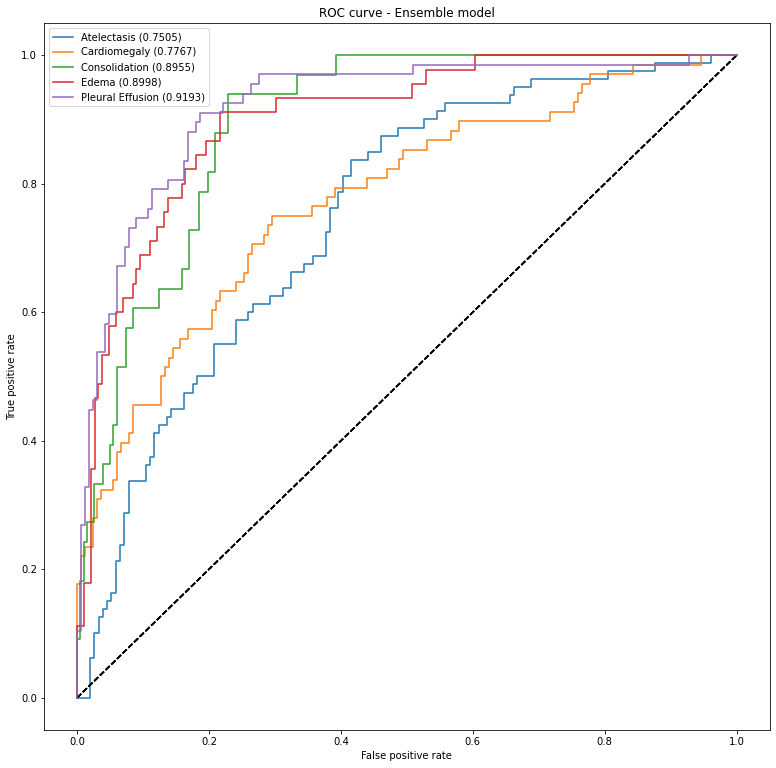

In [39]:
auc_roc_values = []

for i in range(len(labels)):
    try:
        y_true = test_datagenerator.labels[:, i]
        y_pred = predictions_ensemble_model_probabilities[:, i]
        
        auc_roc = roc_auc_score(y_true=y_true, y_score=y_pred)
        auc_roc_values.append(auc_roc)
        
        false_positive_rates, true_positive_rates, _ = roc_curve(y_true=y_true, y_score=y_pred)

        plt.figure(1, figsize=(13, 13))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(
            false_positive_rates,
            true_positive_rates,
            label=labels[i] + " (" + str(round(auc_roc, 4)) + ")"
        )
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve - Ensemble model')
        plt.legend(loc='best')
    except:
        print(
            f"Error in generating ROC curve for {labels[i]}. "
            f"Dataset lacks enough examples."
        )

plt.show()

In [40]:
auc_roc_values

[0.750487012987013,
 0.776665485471297,
 0.8955223880597015,
 0.8998236331569665,
 0.9192957368844401]